In [1]:
! pip install boto3 == 1.28.53 transformers ekphrasis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 109.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      

In [2]:
! pip install --upgrade urllib3 == 2.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.16
    Uninstalling urllib3-1.26.16:
      Successfully uninstalled urllib3-1.26.16
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.31.57 requires urllib3<1.27,>=1.25.4, but you have urllib3 2.0.3 which is incompatible.


In [12]:
! git clone https://github.com/StepanTita/attattr.git
! git clone https://github.com/hate-alert/HateXplain.git

Cloning into 'attattr'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 56 (delta 25), reused 46 (delta 19), pack-reused 0
Receiving objects: 100% (56/56), 1.06 MiB | 8.96 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Cloning into 'HateXplain'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 414 (delta 111), reused 106 (delta 99), pack-reused 280
Receiving objects: 100% (414/414), 6.76 MiB | 19.07 MiB/s, done.
Resolving deltas: 100% (229/229), done.


In [1]:
import sys

sys.path.append('/content/attattr')
sys.path.append('/Users/stepantytarenko/Sandbox/Projects')
sys.path.append('/Users/stepantytarenko/Sandbox/Projects/HateXplain')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, SequentialSampler, DataLoader
from PIL import Image, ImageDraw

from tqdm import tqdm

from transformers import BertTokenizer, BertPreTrainedModel

from HateXplain.TensorDataset.datsetSplitter import createDatasetSplit

from pytorch_pretrained_bert.model_attr import BertPooler, BertModel

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/stepantytarenko/opt/anaconda3/envs/minitorch/lib/python3.10/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


/Users/stepantytarenko/opt/anaconda3/envs/minitorch/lib/python3.10/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...


In [3]:
def on_gpu(f):
    def wrapper():
        if torch.cuda.is_available():
            return f()
        else:
            print('cuda unavailable')

    return wrapper

In [4]:
if torch.cuda.is_available():
    ! pip install pynvml
    from pynvml import *
    from numba import cuda


@on_gpu
def print_gpu_utilization():
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used // 1024 ** 2} MB.")
    except Exception as e:
        print(e)


@on_gpu
def free_gpu_cache():
    print("Initial GPU Usage")
    print_gpu_utilization()

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization()

In [5]:
print_gpu_utilization()
free_gpu_cache()

cuda unavailable
cuda unavailable


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()

In [7]:
BATCH_SIZE = 2
NUM_BATCH = 5

MAX_SEQ_LEN = 128

num_layer = 12
num_head = 12

In [8]:
tokenizer = BertTokenizer.from_pretrained('Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two')

In [9]:
inputs = tokenizer([
    'guilty until proven innocent unless you are a jew a nigger or a lover of both',
    'and this is why i end up with nigger trainee doctors who can not speak properly lack basic knowledge of biology'
], return_tensors='pt', max_length=MAX_SEQ_LEN, padding='max_length', truncation=True).to(device)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0], skip_special_tokens=False)
label_ids = torch.tensor([1, 1], dtype=torch.long).to(device)

In [10]:
tokens = [token for token in tokens if token not in ['[PAD]']]
tokens

['[CLS]',
 'guilty',
 'until',
 'proven',
 'innocent',
 'unless',
 'you',
 'are',
 'a',
 'jew',
 'a',
 'ni',
 '##gger',
 'or',
 'a',
 'lover',
 'of',
 'both',
 '[SEP]']

In [11]:
params = {
    'num_classes': 2,
    'data_file': 'HateXplain/Data/dataset.json',
    'class_label': 'HateXplain/Data/classes_two.npy',
    'class_names': ['NORMAL', 'ABUSIVE'],
    'bert_tokens': True,
    'include_special': True,

    'type_attention': 'softmax',
    'max_length': 128,
    'variance': 10,
    'decay': False,
    'majority': 2,
}

In [12]:
! mkdir Data
! cp HateXplain/Data/* Data/

mkdir: Data: File exists


In [13]:
train, val, test = createDatasetSplit(params)

In [14]:
def transform_data(data, max_len):
    def pad_truncate(record):
        out = record
        if len(out) > max_len:
            out = out[:max_len]
        elif len(out) < max_len:
            out = out + [0] * (max_len - len(out))

        return out

    input_ids = []
    segment_ids = []
    attention_mask = []
    labels = []
    for e in tqdm(data):
        attention_mask.append(np.array([1] * len(e[0]) + [0] * (max_len - len(e[0]))))
        input_ids.append(np.array(pad_truncate(e[0])))
        segment_ids.append(np.array([0] * max_len))
        if e[2] in ['hatespeech', 'offensive']:
            labels.append(1)
        else:
            labels.append(0)
    return {
        'input_ids': torch.tensor(input_ids, dtype=torch.long),
        'token_type_ids': torch.tensor(segment_ids, dtype=torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
        'label_ids': torch.tensor(labels, dtype=torch.long),
    }

In [15]:
val_ready = transform_data(val, MAX_SEQ_LEN)
val_ready

100%|██████████| 1922/1922 [00:00<00:00, 34509.35it/s]
/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_43237/1555435426.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343679700/work/torch/csrc/utils/tensor_new.cpp:248.)
  'input_ids': torch.tensor(input_ids, dtype=torch.long),


{'input_ids': tensor([[  101,  2023,  7743,  ...,     0,     0,     0],
         [  101,  5458,  1045,  ...,     0,     0,     0],
         [  101,  2035,  1997,  ...,     0,     0,     0],
         ...,
         [  101, 10629,  2358,  ...,     0,     0,     0],
         [  101,  2019, 12632,  ...,     0,     0,     0],
         [  101,  2065, 24471,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'label_ids': tensor([1, 1, 1,  ..., 0, 0, 1])}

In [16]:
test_ready = transform_data(test, MAX_SEQ_LEN)
test_ready

100%|██████████| 1924/1924 [00:00<00:00, 39562.70it/s]


{'input_ids': tensor([[ 101, 1045, 2123,  ...,    0,    0,    0],
         [ 101, 6874, 8840,  ...,    0,    0,    0],
         [ 101, 5310, 2054,  ...,    0,    0,    0],
         ...,
         [ 101, 2129, 2003,  ...,    0,    0,    0],
         [ 101, 2092, 2026,  ...,    0,    0,    0],
         [ 101, 2021, 2009,  ...,    0,    0,    0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'label_ids': tensor([0, 1, 0,  ..., 1, 1, 0])}

In [17]:
def scaled_input(emb, batch_size, num_batch, baseline=None, start_i=None, end_i=None):
    # shape of emb: (num_head, seq_len, seq_len)
    if baseline is None:
        baseline = torch.zeros_like(emb)

    num_points = batch_size * num_batch
    scale = 1.0 / num_points
    if start_i is None:
        step = (emb.unsqueeze(0) - baseline.unsqueeze(0)) * scale  # (1, num_head, seq_len, seq_len)
        # n = batch_size * num_batch
        res = torch.cat([torch.add(baseline.unsqueeze(0), step * i) for i in range(num_points)],
                        dim=0)  # (n, num_head, seq_len, seq_len)
        return res, step[0]
    else:
        step = (emb - baseline) * scale
        start_emb = torch.add(baseline, step * start_i)
        end_emb = torch.add(baseline, step * end_i)
        step_new = (end_emb.unsqueeze(0) - start_emb.unsqueeze(0)) * scale
        res = torch.cat([torch.add(start_emb.unsqueeze(0), step_new * i) for i in range(num_points)], dim=0)
        return res, step_new[0]

In [92]:
def generate_attr_score(model, dataloader, batch_size, num_batch):
    res_attr = []

    for input_ids, segment_ids, attention_mask, label_ids in tqdm(dataloader):
        input_ids = input_ids.to(device)
        segment_ids = segment_ids.to(device)
        attention_mask = attention_mask.to(device)
        label_ids = label_ids.to(device)

        layers_attr = []

        for tar_layer in range(num_layer):
            with torch.no_grad():
                att, baseline_logits, _ = model(input_ids=input_ids, token_type_ids=segment_ids,
                                                attention_mask=attention_mask,
                                                labels=label_ids, tar_layer=tar_layer)
            pred_label = torch.argmax(baseline_logits, dim=1)

            scale_att, step = scaled_input(att.data, batch_size, num_batch)
            scale_att.requires_grad_(True)

            attr_all = None
            for j_batch in range(num_batch):
                one_batch_att = scale_att[j_batch * batch_size:(j_batch + 1) * batch_size]
                tar_prob, grad = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=attention_mask,
                                       labels=label_ids, tar_layer=tar_layer, tmp_score=one_batch_att,
                                       pred_label=pred_label)
                print(len(grad))
                print(grad[0].shape)
                grad = grad.sum(dim=0)
                attr_all = grad if attr_all is None else torch.add(attr_all, grad)
            layers_attr.append(attr_all.data.cpu().detach().numpy())
        res_attr.append(np.array(layers_attr))

    return np.array(res_attr).sum(1).sum(1)

In [93]:
class Model_Rational_Label(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = 2
        self.impact_factor = 0.8
        self.bert = BertModel(config, add_pooling_layer=False)
        self.bert_pooler = BertPooler(config)
        self.token_dropout = nn.Dropout(0.1)
        self.token_classifier = nn.Linear(config.hidden_size, 2)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.init_weights()

    def forward(self,
                input_ids=None,
                attention_mask=None,
                token_type_ids=None,
                attn=None,
                labels=None,
                tar_layer=None,
                tmp_score=None,
                pred_label=None):
        _, sequence_output, att_score = self.bert(
            input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask,
            output_all_encoded_layers=False,
            tar_layer=tar_layer, tmp_score=tmp_score)

        token_logits = self.token_classifier(self.token_dropout(sequence_output))

        #         mean_pooling = torch.mean(out, 1)
        #         max_pooling, _ = torch.max(out, 1)
        #         embed = torch.cat((mean_pooling, max_pooling), 1)
        embed = self.bert_pooler(sequence_output)
        logits = self.classifier(self.dropout(embed))

        prob = torch.nn.functional.softmax(logits, dim=-1)

        if labels is not None:
            tar_prob = prob[:, labels[0]]

        if tmp_score is None:
            return att_score[0], logits, token_logits
        else:
            # gradient = torch.autograd.grad(torch.unbind(prob[:, labels[0]]), tmp_score)
            gradient = torch.autograd.grad(torch.unbind(torch.gather(prob, dim=1, index=labels.view(-1, 1))), tmp_score)
            return tar_prob, gradient[0]

In [90]:
model = Model_Rational_Label.from_pretrained('Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two').to(device)
model

Model_Rational_Label(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
     

In [71]:
def return_dataloader(input_ids, token_type_ids, att_masks, labels, batch_size):
    inputs = torch.tensor(input_ids)
    labels = torch.tensor(labels, dtype=torch.long)
    masks = torch.tensor(np.array(att_masks), dtype=torch.uint8)
    data = TensorDataset(inputs, token_type_ids, masks, labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dataloader

In [22]:
val_ready['label_ids'], label_ids

(tensor([1, 1, 1,  ..., 0, 0, 1]), tensor([1, 1]))

In [23]:
dataloader = return_dataloader(val_ready['input_ids'], val_ready['token_type_ids'], val_ready['attention_mask'],
                               val_ready['label_ids'], BATCH_SIZE)
dataloader

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_43237/1897980149.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(input_ids)
/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_43237/1897980149.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


In [94]:
res_attr = generate_attr_score(
    model,
    dataloader,
    batch_size=BATCH_SIZE,
    num_batch=NUM_BATCH
)
res_attr

  0%|          | 0/961 [00:02<?, ?it/s]

1
torch.Size([2, 12, 128, 128])


AttributeError: 'tuple' object has no attribute 'sum'

In [70]:
res_attr = []

input_ids = inputs['input_ids']
segment_ids = inputs['token_type_ids']
attention_mask = inputs['attention_mask']
label_ids = label_ids

layers_attr = []

for tar_layer in range(num_layer):
    att, baseline_logits, _ = model(input_ids=input_ids, token_type_ids=segment_ids,
                                    attention_mask=attention_mask,
                                    labels=label_ids, tar_layer=tar_layer)
    pred_label = torch.argmax(baseline_logits, dim=1)

    scale_att, step = scaled_input(att.data, BATCH_SIZE, NUM_BATCH)
    scale_att.requires_grad_(True)

    attr_all = None
    for j_batch in range(NUM_BATCH):
        one_batch_att = scale_att[j_batch * BATCH_SIZE:(j_batch + 1) * BATCH_SIZE]
        tar_prob, grad = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=attention_mask,
                               labels=label_ids, tar_layer=tar_layer, tmp_score=one_batch_att,
                               pred_label=pred_label)
        grad = grad.sum(dim=0)
        attr_all = grad if attr_all is None else torch.add(attr_all, grad)
    layers_attr.append(attr_all.data.cpu().detach().numpy())
res_attr.append(np.array(layers_attr))

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [48]:
np.array(res_attr).shape

(2, 128, 128)

In [49]:
total_attr = res_attr[0, :inputs['attention_mask'][0].sum(), :inputs['attention_mask'][0].sum()]
total_attr = total_attr / total_attr.sum()
total_attr.shape

(19, 19)

In [52]:
def plot_parallel(matrix, tokens):
    # Set figsize
    plt.figure(figsize=(12, 8))

    input_len = len(tokens)

    # Vertical lines for the years
    plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=5, color='black', linestyle='--', linewidth=1)

    # Add the BEFORE and AFTER
    plt.text(1, input_len + 1, 'A', fontsize=12, color='black', fontweight='bold')
    plt.text(5, input_len + 1, 'B', fontsize=12, color='black', fontweight='bold')

    # Plot the line for each continent
    for i in range(input_len):
        for j in range(input_len):
            # Add the line to the plot
            plt.plot([1, 5], [i, j], marker='o', label='token', color='blue', linewidth=1 * matrix[i][j])

            # Add label of each continent at each year
            plt.text(
                1 - 0.18,  # x-axis position
                i,  # y-axis position
                tokens[i],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color,
            )

            plt.text(
                5 + 0.06,  # x-axis position
                j,  # y-axis position
                tokens[j],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color
            )
        break

    # Add a title ('\n' allow us to jump lines)
    plt.title(f'AttrAttr scores \n\n\n')

    plt.yticks([])  # Remove y-axis
    plt.box(False)  # Remove the bounding box around plot
    plt.show()  # Display the chart

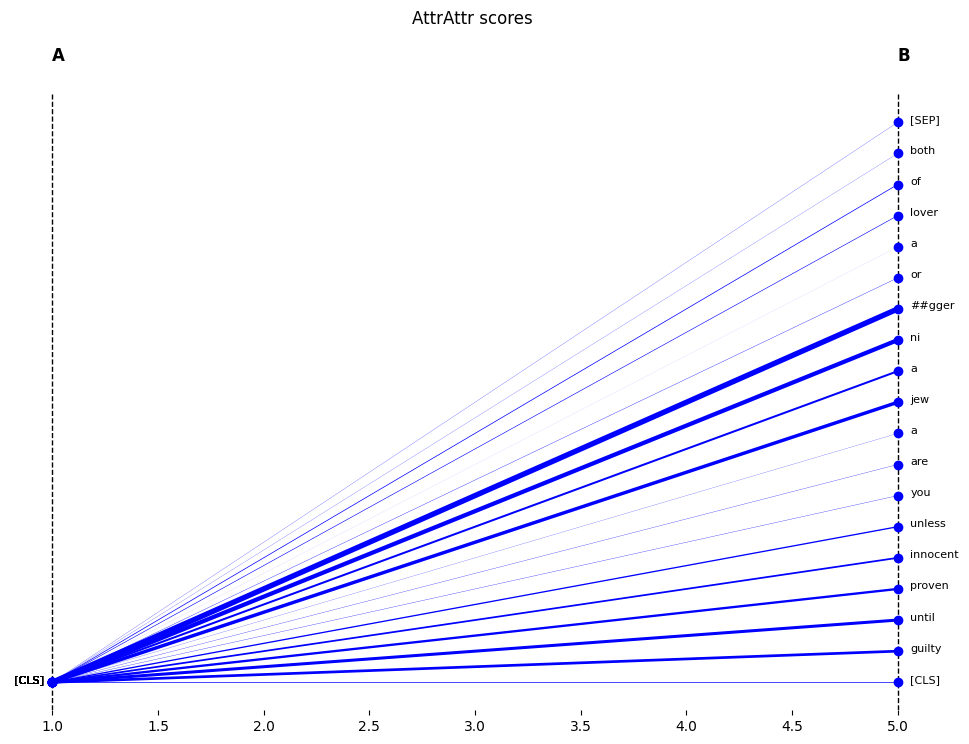

In [53]:
plot_parallel(total_attr, tokens)

In [54]:
_, prediction_logits, token_logits = model(input_ids=inputs['input_ids'], token_type_ids=inputs['token_type_ids'],
                                           attention_mask=inputs['attention_mask'], tar_layer=0)

torch.nn.functional.softmax(prediction_logits)

<ipython-input-42-f09f14c236f2>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = torch.nn.functional.softmax(logits)
<ipython-input-54-53af0c419cc2>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(prediction_logits)


tensor([[0.0231, 0.9769],
        [0.0623, 0.9377]], grad_fn=<SoftmaxBackward0>)

In [56]:
input_len = inputs['attention_mask'][0].sum()

In [57]:
pred_tokens = torch.nn.functional.softmax(token_logits, dim=-1)[:, :input_len, :]
pred_tokens

tensor([[[9.9875e-01, 1.2473e-03],
         [9.9580e-01, 4.1996e-03],
         [9.9657e-01, 3.4278e-03],
         [9.9555e-01, 4.4473e-03],
         [9.9530e-01, 4.7008e-03],
         [9.7589e-01, 2.4106e-02],
         [9.6882e-01, 3.1180e-02],
         [9.7830e-01, 2.1697e-02],
         [9.7018e-01, 2.9817e-02],
         [3.8503e-01, 6.1497e-01],
         [7.4652e-01, 2.5348e-01],
         [2.2920e-02, 9.7708e-01],
         [1.7939e-02, 9.8206e-01],
         [9.2602e-01, 7.3980e-02],
         [9.7907e-01, 2.0928e-02],
         [8.9924e-01, 1.0076e-01],
         [8.9317e-01, 1.0683e-01],
         [9.5001e-01, 4.9993e-02],
         [9.9996e-01, 4.4781e-05]],

        [[9.9961e-01, 3.8629e-04],
         [9.9975e-01, 2.5239e-04],
         [9.9978e-01, 2.1731e-04],
         [9.9978e-01, 2.2005e-04],
         [9.9984e-01, 1.6181e-04],
         [9.9974e-01, 2.5949e-04],
         [9.9962e-01, 3.8302e-04],
         [9.9967e-01, 3.2515e-04],
         [9.9970e-01, 2.9545e-04],
         [3.8896e-

In [58]:
id2label = {
    0: 'NEUTRAL',
    1: 'ABUSIVE'
}

In [59]:
tokens_classes = torch.argmax(pred_tokens, dim=2)[0]

In [60]:
for i, token_label in enumerate(tokens_classes):
    print(f'{tokens[i]} ({id2label[token_label.item()]})', end=' ')

[CLS] (NEUTRAL) guilty (NEUTRAL) until (NEUTRAL) proven (NEUTRAL) innocent (NEUTRAL) unless (NEUTRAL) you (NEUTRAL) are (NEUTRAL) a (NEUTRAL) jew (ABUSIVE) a (NEUTRAL) ni (ABUSIVE) ##gger (ABUSIVE) or (NEUTRAL) a (NEUTRAL) lover (NEUTRAL) of (NEUTRAL) both (NEUTRAL) [SEP] (NEUTRAL) 

In [61]:
def generate_text_highlighted(preds, tokens, canvas=(450, 300)):
    im = Image.new(mode='RGBA', size=canvas, color=(255, 255, 255, 255))

    img = ImageDraw.Draw(im)

    def highlight(xy, wh, color):
        img.rectangle(xy=(xy[0] - 0.5, xy[1] - 0.5, xy[0] + wh[0], xy[1] + wh[1]), fill=color)  # , outline='red'

    # highlight((28, 36), wh=(5, 12), color=(255, 0, 0, 100))
    # img.text((28, 36), 'nice Car', fill=(0, 0, 0, 200))

    x = 28
    y = 36
    for i, token in enumerate(tokens):
        if preds[i] == 1:
            x += 3
            highlight((x, y), wh=(6 * len(token), 12), color=(255, 0, 0, 100))
            img.text((x, y), token, fill=(0, 0, 0, 200))
        else:
            img.text((x, y), token, fill=(0, 0, 0, 255))

        x += 1.4 * 5 * len(token)
        if x + 35 >= canvas[0]:
            x = 28
            y += 1.4 * 7

    return im

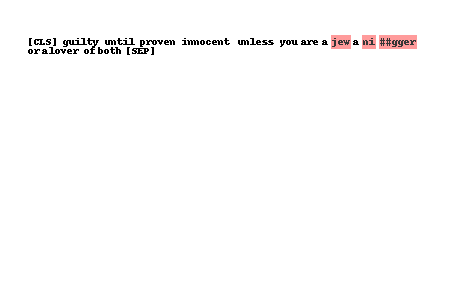

In [62]:
generate_text_highlighted(tokens_classes, tokens)